In [ ]:
import stVGP
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import os
from matplotlib.image import imread

import warnings
warnings.filterwarnings("ignore")

d:\anaconda\envs\xw_cuda117\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rep_10 = pd.read_csv('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Raw_data/Rep10_MOB_count_matrix-1.tsv',sep='\t')
rep_11 = pd.read_csv('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Raw_data/Rep11_MOB_count_matrix-1.tsv',sep='\t')
rep_12 = pd.read_csv('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Raw_data/Rep12_MOB_count_matrix-1.tsv',sep='\t')

rep_10_spot_names = rep_10['Unnamed: 0'].str.split('x')
rep_10_x_spatial,rep_10_y_spatial = rep_10_spot_names.str[0],rep_10_spot_names.str[1]
rep_10_spatial = np.hstack((np.array(rep_10_x_spatial).reshape(-1,1),np.array(rep_10_y_spatial).reshape(-1,1)))
rep_10_var_names = np.array(rep_10.columns[1:])
rep_10_obs_names = np.array(rep_10['Unnamed: 0'])
count_matrix_rep_10 = rep_10.values[:,1:]
print(count_matrix_rep_10.shape)
rep_11_spot_names = rep_11['Unnamed: 0'].str.split('x')
rep_11_x_spatial,rep_11_y_spatial = rep_11_spot_names.str[0],rep_11_spot_names.str[1]
rep_11_spatial = np.hstack((np.array(rep_11_x_spatial).reshape(-1,1),np.array(rep_11_y_spatial).reshape(-1,1)))
rep_11_var_names = np.array(rep_11.columns[1:])
rep_11_obs_names = np.array(rep_11['Unnamed: 0'])
count_matrix_rep_11 = rep_11.values[:,1:]
print(count_matrix_rep_11.shape)
rep_12_spot_names = rep_12['Unnamed: 0'].str.split('x')
rep_12_x_spatial,rep_12_y_spatial = rep_12_spot_names.str[0],rep_12_spot_names.str[1]
rep_12_spatial = np.hstack((np.array(rep_12_x_spatial).reshape(-1,1),np.array(rep_12_y_spatial).reshape(-1,1)))
rep_12_var_names = np.array(rep_12.columns[1:])
rep_12_obs_names = np.array(rep_12['Unnamed: 0'])
count_matrix_rep_12 = rep_12.values[:,1:]
print(count_matrix_rep_12.shape)
slice_use = ['Replicate 10','Replicate 11','Replicate 12']

adata_rep_10 = ad.AnnData(X=count_matrix_rep_10)
adata_rep_10.obs.index = rep_10_obs_names
adata_rep_10.var.index = rep_10_var_names
adata_rep_10.obs['samples_idx'] = np.array(['Replicate 10'] * count_matrix_rep_10.shape[0]).ravel()
adata_rep_10.obsm['spatial'] = np.array(rep_10_spatial,dtype = np.float32)
adata_rep_10.obsm['loc_use'] = np.array(rep_10_spatial,dtype = np.float32)
adata_rep_10.obsm['raw_count'] = np.array(count_matrix_rep_10,dtype = np.float32)

adata_rep_11 = ad.AnnData(X=count_matrix_rep_11)
adata_rep_11.obs.index = rep_11_obs_names
adata_rep_11.var.index = rep_11_var_names
adata_rep_11.obs['samples_idx'] = np.array(['Replicate 11'] * count_matrix_rep_11.shape[0]).ravel()
adata_rep_11.obsm['spatial'] = np.array(rep_11_spatial,dtype = np.float32)
adata_rep_11.obsm['loc_use'] = np.array(rep_11_spatial,dtype = np.float32)
adata_rep_11.obsm['raw_count'] = np.array(count_matrix_rep_11,dtype = np.float32)

adata_rep_12 = ad.AnnData(X=count_matrix_rep_12)
adata_rep_12.obs.index = rep_12_obs_names
adata_rep_12.var.index = rep_12_var_names
adata_rep_12.obs['samples_idx'] = np.array(['Replicate 12'] * count_matrix_rep_12.shape[0]).ravel()
adata_rep_12.obsm['spatial'] = np.array(rep_12_spatial,dtype = np.float32)
adata_rep_12.obsm['loc_use'] = np.array(rep_12_spatial,dtype = np.float32)
adata_rep_12.obsm['raw_count'] = np.array(count_matrix_rep_12,dtype = np.float32)

adata_concat = ad.concat([adata_rep_10,adata_rep_11,adata_rep_12])

sc.pp.filter_cells(adata_concat, min_genes = 1)
sc.pp.filter_genes(adata_concat, min_cells = 1)
sc.pp.normalize_total(adata_concat, inplace=True)
sc.pp.log1p(adata_concat)

sc.pp.neighbors(adata_concat,use_rep='X',n_neighbors=5)
sc.tl.umap(adata_concat)
sc.tl.louvain(adata_concat, resolution=0.8)

adata_adjust = adata_concat[adata_concat.obs['louvain'] != '3']

sc.pp.neighbors(adata_adjust,use_rep='X',n_neighbors=15)
sc.tl.umap(adata_adjust)
sc.tl.louvain(adata_adjust, resolution=1.0)

slice_list = []
for slice_name in slice_use:
    slice_list.append(adata_adjust[adata_adjust.obs['samples_idx']==slice_name])

for slice_index in range(len(slice_list)):
    slice_list[slice_index] = slice_list[slice_index][slice_list[slice_index].obs['louvain'] != '4']

adata_common_list = []
for adata_index in range(len(slice_list)):
    adata_st_new = slice_list[adata_index].copy()
    sc.pp.highly_variable_genes(adata_st_new, flavor = 'seurat', n_top_genes = 5000)
    adata_subset = adata_st_new[:, adata_st_new.var['highly_variable']]
    adata_common_list.append(adata_subset)
common_genes = np.array(adata_common_list[0].var_names)
for adata in adata_common_list[1:]:
    common_genes = np.intersect1d(common_genes,np.array(adata.var_names))
adata_list = [adata[:, list(common_genes)] for adata in adata_common_list]

(281, 16416)
(262, 16218)
(282, 16034)


In [3]:
# slice_use = ['MOB_replicate_10','MOB_replicate_11','MOB_replicate_12']
# for adata_index in range(len(adata_list)):
#     adata_list[adata_index].write("C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Raw_data/{}_slice.h5ad".format(slice_use[adata_index]))

In [ ]:
import os 
for ref_index in range(len(adata_list)):
    if not os.path.exists("C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/select_gene/{}".format(ref_index)):
        os.makedirs("C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/select_gene/{}".format(ref_index))
    adata_list = stVGP.select_gene(adata_list,
                                    ref_adata_num=ref_index,
                                    spot_make=2,
                                    save_data=False,
                                    key_words = 'loc_use',
                                    savepath='C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/select_gene/{}/'.format(ref_index))

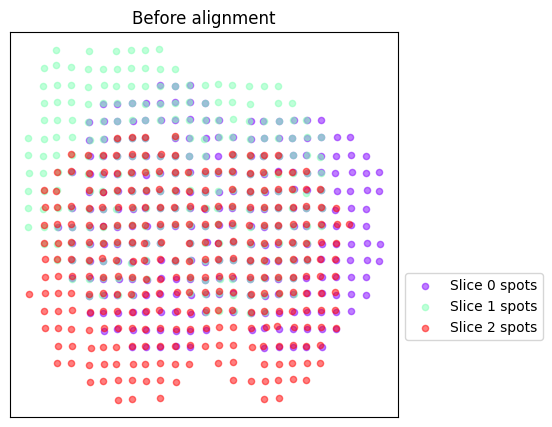

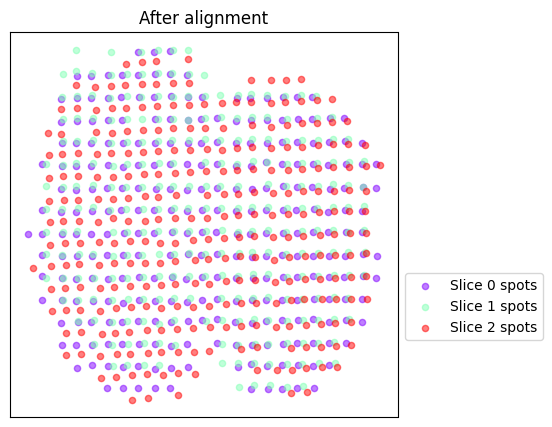

In [ ]:
file_path = 'C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/select_gene'
gene_input_list = []
for i in range(len(adata_list)):
    gene_morans_result = np.genfromtxt(file_path + '/{}/gene_morans_4.txt'.format(i),
                                   dtype=np.str0,
                                   skip_header=1,
                                   delimiter ='\t')
    sorted_indices = np.argsort(gene_morans_result[:,-1])[::-1]
    top_morans_indices = sorted_indices[:1]
    select_gene_final = gene_morans_result[top_morans_indices,0]
    gene_input_list.append(select_gene_final)

adata_list = stVGP.gene_rigid_alignment(
        gene_input = gene_input_list[0],
        stadata_input = adata_list,
        ini_spatial = 'loc_use',
        add_spatial = 'align_spatial',
        align_model = "single_template_alignment",
        gene_input_list = gene_input_list,
        ref_label = 0,
        align_method = 'optimize',
        icp_iterations = 20,                          
        maxiter = 300
)

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

cmap = cm.get_cmap('rainbow', len(adata_list))
colors_list = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(len(adata_list))]

# Plot spots before alignment
plt.figure(figsize=(5, 5))
plt.title("Before alignment")
for i in range(len(adata_list)):
    plt.scatter(adata_list[i].obsm['loc_use'][:, 0], 
        adata_list[i].obsm['loc_use'][:, 1], 
        c=colors_list[i],
        label="Slice %d spots" % i, s=20., alpha=0.5)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.xticks([])
plt.yticks([])
plt.legend(loc=(1.02, .2), ncol=(len(adata_list)//13 + 1))
plt.show()

cmap = cm.get_cmap('rainbow', len(adata_list))
colors_list = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(len(adata_list))]

# Plot spots before alignment
plt.figure(figsize=(5, 5))
plt.title("After alignment")
for i in range(len(adata_list)):
    plt.scatter(adata_list[i].obsm['align_spatial'][:, 0], 
        adata_list[i].obsm['align_spatial'][:, 1], 
        c=colors_list[i],
        label="Slice %d spots" % i, s=20., alpha=0.5)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.xticks([])
plt.yticks([])
plt.legend(loc=(1.02, .2), ncol=(len(adata_list)//13 + 1))
plt.show()

In [6]:
# slice_use = ['MOB_replicate_10','MOB_replicate_11','MOB_replicate_12']
# for adata_index in range(len(adata_list)):
#     adata_list[adata_index].write("C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/{}_slice.h5ad".format(slice_use[adata_index]))

In [7]:
work_path = "C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/"
slice_use = ['MOB_replicate_10','MOB_replicate_11','MOB_replicate_12']
adata_MOB = []

for slice in slice_use:
    file_path = work_path + str(slice) + '_slice.h5ad'
    adata = sc.read(file_path)
    adata_MOB.append(adata)

adata_dim = []
for adata_index,adata in enumerate(adata_MOB):
    adata_dim.append(adata_MOB[adata_index].X.shape[0])
adata_cum = np.cumsum(adata_dim)
adata_cum = np.insert(adata_cum,0,0)

In [ ]:
# Preprocessed data
# If the data was not processed during the alignment process, perform preliminary processing of the data
slice_matrix,adj_matrix = stVGP.adata_preprocess_adjnet(
                    input_adata = adata_MOB,
                    align_model = 'single_template_alignment',
                    spatial_label = 'align_spatial',
                    add_net_keywords_self = 'adj_spatial_net',
                    n_neighbors = 15,
                    ref_label = 0,                             
                    no_cross = False)

In [ ]:
import torch

recon_x, embedding, model_params,logvar = stVGP.train_stVGP(
        ST_need_reconstruction_matrix = slice_matrix,
        all_spatial_net = adj_matrix,
        lr = 0.0001,
        weight_decay = 0.0001,
        training_epoch = 1000,
        num_heads = 1,
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        save_model = False,
        save_model_path = 'path',
        hidden_embedding = [128,26],
        random_seed = 508,
        optimize_method = 'adam',
        whether_gradient_clipping = False,
        gradient_clipping = 5.0,
        all_gat = False)


Model training


100%|██████████| 1000/1000 [00:20<00:00, 48.61it/s]


In [10]:
# Save embedded layer data
# np.savetxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Domain/embedding.txt',embedding,fmt='%s')
# np.savetxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Domain/logvar.txt',logvar,fmt='%s')

In [16]:
import random

embedding = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Domain/embedding.txt')

random.seed(512)
np.random.seed(512)

# Before connecting, make sure the form
for adata_index in range(len(adata_MOB)):
    adata_MOB[adata_index].obsm['batch_effect_mapping'] = np.array(adata_MOB[adata_index].obsm['batch_effect_mapping']).reshape(-1,1)

resolution = 0.3
n_neighbors_cluster = 8

for adata_index,adata in enumerate(adata_MOB):
    adata_MOB[adata_index].obsm['latent'] = embedding[adata_cum[adata_index]:adata_cum[adata_index+1]]

adata_concat = ad.concat(adata_MOB)

sc.pp.neighbors(adata_concat, use_rep='latent', n_neighbors=n_neighbors_cluster)
sc.tl.umap(adata_concat)
sc.tl.louvain(adata_concat, resolution=resolution)

In [17]:
AP_z = [0.,10.,20.]

for adata_index in range(len(adata_MOB)):
    if adata_index == 0:
        spatial_spots = np.array(adata_MOB[adata_index].obsm['align_spatial'])
        spatial_z = np.array([AP_z[adata_index]]*adata_MOB[adata_index].shape[0]).reshape(-1,1)
    else:
        spatial_spots = np.vstack((spatial_spots,adata_MOB[adata_index].obsm['align_spatial']))
        spatial_z = np.vstack((spatial_z,np.array([AP_z[adata_index]]*adata_MOB[adata_index].shape[0]).reshape(-1,1)))

spatial_spots = np.hstack((spatial_spots,spatial_z))
cluster = np.array(adata_concat.obs['louvain'])

# np.savetxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Domain/alignment_spatial.txt',spatial_spots,fmt='%s')
# np.savetxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Domain/cluster.txt',cluster,fmt='%s')
# torch.save(model_params,"C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Domain/model.pth")

['0' '1' '3' '1' '1' '3' '0' '4' '2' '0' '1' '2' '2' '2' '2' '2' '0' '2'
 '2' '0' '0' '4' '0' '0' '0' '0' '0' '0' '0' '2' '2' '0' '0' '4' '0' '2'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '4' '0' '0' '0' '0' '0' '0' '2' '0' '2' '2' '4' '4' '2' '4' '2' '0' '4'
 '4' '0' '4' '0' '1' '1' '1' '1' '2' '2' '1' '1' '3' '3' '1' '3' '1' '1'
 '3' '1' '1' '3' '3' '1' '0' '0' '0' '2' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '4' '1' '0' '1' '1' '1' '1' '3' '3' '1' '1' '1' '3' '3'
 '3' '1' '2' '2' '4' '0' '3' '1' '3' '2' '1' '2' '2' '2' '0' '4' '0' '2'
 '0' '0' '0' '0' '0' '0' '4' '0' '2' '0' '0' '0' '0' '0' '0' '4' '0' '0'
 '0' '0' '2' '2' '2' '2' '2' '1' '1' '1' '3' '3' '2' '0' '2' '2' '4' '2'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '4' '4' '2' '2' '3' '1' '1' '1' '1'
 '1' '1' '2' '0' '0' '0' '0' '1' '0' '2' '4' '2' '1' '4' '4' '0' '0' '0'
 '1' '3' '3' '3' '2' '3' '1' '3' '2' '2' '2' '2' '2' '3' '4' '4' '2' '2'
 '2' '2' '1' '1' '1' '1' '1' '0' '4' '0' '4' '1' '1

In [ ]:
# Gene prediction
# Masked slices prediction

spatial = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Domain/alignment_spatial.txt')
embedding = np.loadtxt("C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Domain/embedding.txt")

slice_use = ['MOB_replicate_10','MOB_replicate_11','MOB_replicate_12']

for slice_index,slice_name in enumerate(slice_use):

    Train_spatial_up = spatial[:adata_cum[slice_index]]
    Train_spatial_down = spatial[adata_cum[slice_index+1]:]

    Embedding_up = embedding[:adata_cum[slice_index]]
    Embedding_down = embedding[adata_cum[slice_index+1]:]

    Pred_spatial = spatial[adata_cum[slice_index]:adata_cum[slice_index+1]]
    Pred_embedding_true = embedding[adata_cum[slice_index]:adata_cum[slice_index+1]]

    Train_spatial = np.vstack((Train_spatial_up,Train_spatial_down))
    Train_embedding = np.vstack((Embedding_up,Embedding_down))

    pred_embedding = stVGP.get_3D_prediction(
                train_coordinates = Train_spatial,
                embedding = Train_embedding,
                spatial_pred = Pred_spatial,
                noise = False,
                noise_value = 0.00001,
                constant_value = 1.0,
                Rbf_value = 1024)
    
    print(pred_embedding.shape)

    # np.savetxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Prediction and 3D/{}_embedding.txt'.format(slice_use[slice_index]),pred_embedding,fmt='%s')

(278, 26)
(258, 26)
(275, 26)


In [ ]:
# reload data
data_path = 'C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/'
slice_use = ['MOB_replicate_10','MOB_replicate_11','MOB_replicate_12']
adata_list = []
for slice_name in slice_use:
    file_name = data_path + slice_name + '_slice.h5ad'
    adata = sc.read(file_name)
    adata_list.append(adata)

slice_matrix,adj_matrix = stVGP.adata_preprocess_adjnet(
                    input_adata = adata_list,
                    align_model = 'single_template_alignment',
                    spatial_label = 'align_spatial',
                    add_net_keywords_self = 'adj_spatial_net',
                    n_neighbors = 15,
                    ref_label = 0,                             
                    no_cross = False)

for adata_index in range(len(adata_list)):
    adata_list[adata_index].obsm['batch_effect_mapping'] = np.array(adata_list[adata_index].obsm['batch_effect_mapping']).reshape(-1,1)

slice_matrix = torch.tensor(slice_matrix,dtype=torch.float32)
edge_list = []
edge_list.append(adj_matrix.row.tolist())
edge_list.append(adj_matrix.col.tolist())
adj_tensor = torch.LongTensor(edge_list)

slice_use = ['MOB_replicate_10','MOB_replicate_11','MOB_replicate_12']
for slice_index,slice_name in enumerate(slice_use):
    if slice_index == 0:
        prediction_embedding = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Prediction and 3D/{}_embedding.txt'.format(slice_name))
    else:
        input_embedding = np.loadtxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Prediction and 3D/{}_embedding.txt'.format(slice_name))
        prediction_embedding = np.vstack((prediction_embedding,input_embedding))
prediction_embedding = torch.tensor(prediction_embedding,dtype=torch.float32)

In [26]:
model_path = 'C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Domain/' 
checkpoint = torch.load(model_path + 'model.pth')

In [ ]:
Gene_reconstruction = stVGP.gene_prediction(
    slice_matrix = slice_matrix,
    prediction_embedding = prediction_embedding,               
    adj_matrix = adj_tensor,                        
    checkpoint = checkpoint,                         
    model_layer = [slice_matrix.shape[1],128,26,1],                       
    all_gat = False,                            
    logvar = None,                            
    device = torch.device('cuda:0')
)

In [28]:
np.savetxt('C:/Users/wzd/Desktop/Alignment Domain Prediction/mob/Prediction and 3D/Gene_reconstruction.txt',Gene_reconstruction,fmt='%s')